In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> Brain Tumor Detection using Pre-Trained DenseNet-169 model </h1>

<p> In this notebook, detection of Brain tumors has been done by using Computer Vision. A pre-trained DenseNet-169 model with ImageNet weights has been used to perform this task. Keras API and tensorflow have been used in this notebook </p>

<h2> Importing necessary Libraries </h2>

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy
import random
import os

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = "/content/drive/My Drive/dataset_16"
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
base_output_dir = "/content/drive/My Drive"

# Create directories
for split in ['TRAIN', 'TEST', 'VAL']:
    for category in categories:
        os.makedirs(os.path.join(base_output_dir, split, category), exist_ok=True)

# Function to split data
def split_data(base_dir, category, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    # Ensure the split sizes sum to 1
    assert train_size + val_size + test_size == 1, "Train, Validation and Test sizes should sum to 1"

    # Get list of files
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path)

    # Split files into train, validation and test sets
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_size/(val_size+test_size), random_state=42)

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'TRAIN', category, file))

    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'VAL', category, file))

    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, 'TEST', category, file))

# Split data for each category
for category in categories:
    split_data(base_dir, category, base_output_dir)

# Print directory structure
!apt-get install tree
!tree -d /content


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (82.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121926 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
├── drive
│   └── MyDrive
│       ├── Business Ideas
│       ├── CARE Testimonials - Concert -> /content/drive/.shortcut-targets-by-id/0B3ZZuq9qOQ9hdVBNLXNCdEtZN2c/CARE Testimonials - Concert
│       ├── CMSK1
│       ├── Colab Notebooks
│       ├── cora
│       │   └── cora
│ 

In [ ]:
# Constants
IMG_SIZE = (224, 224)  # Change this if you need different dimensions

def load_data(data_dir, img_size):
    data = []
    labels = []
    class_labels = []
    categories = os.listdir(data_dir)

    for category in categories:
        class_path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # Label encoding
        class_labels.append(category)

        for img in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img)
                img_array = cv2.imread(img_path)  # Read image
                resized_array = cv2.resize(img_array, img_size)  # Resize image
                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    data = np.array(data)
    labels = np.array(labels)

    return data, labels, class_labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [ ]:
TRAIN_DIR = '/content/drive/My Drive/TRAIN/'
TEST_DIR = '/content/drive/My Drive/TEST/'
VAL_DIR = '/content/drive/My Drive/VAL/'

In [ ]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


<h2> Plotting the number of samples in Training, Validation and Test sets </h2>

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

<h2> Let's Visualize the images we are working with </h2>

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

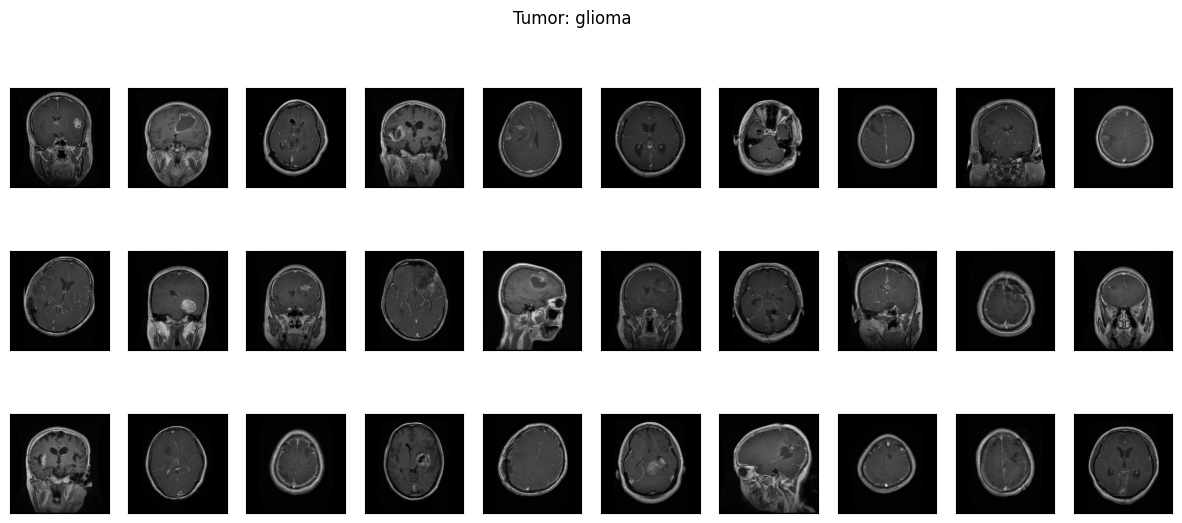

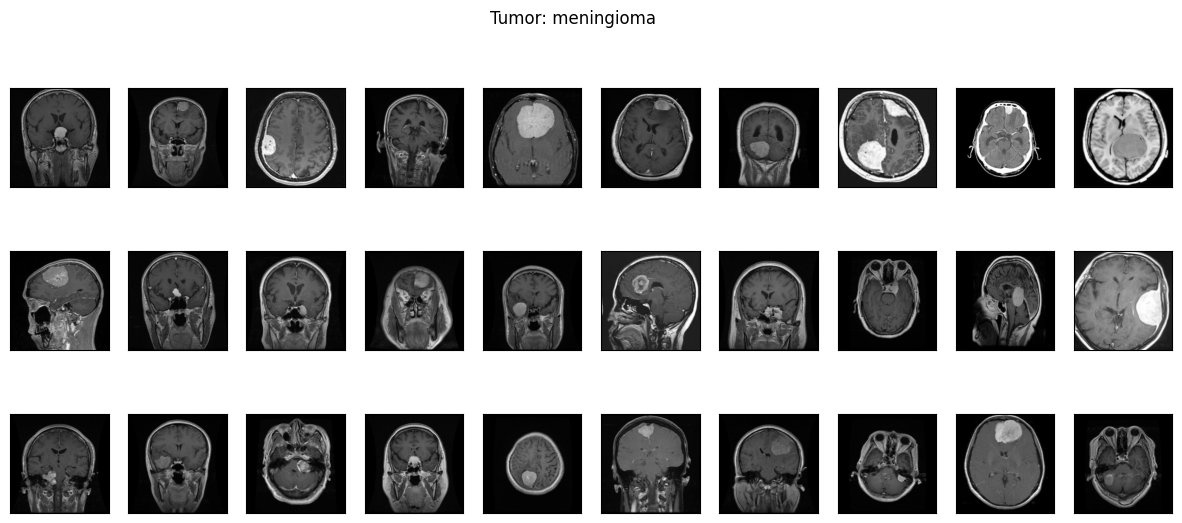

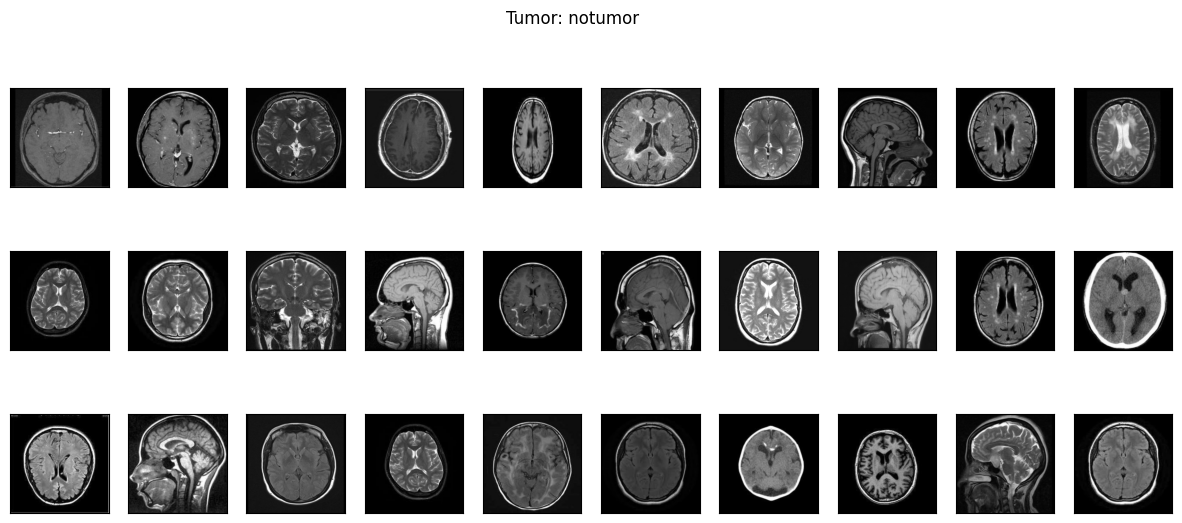

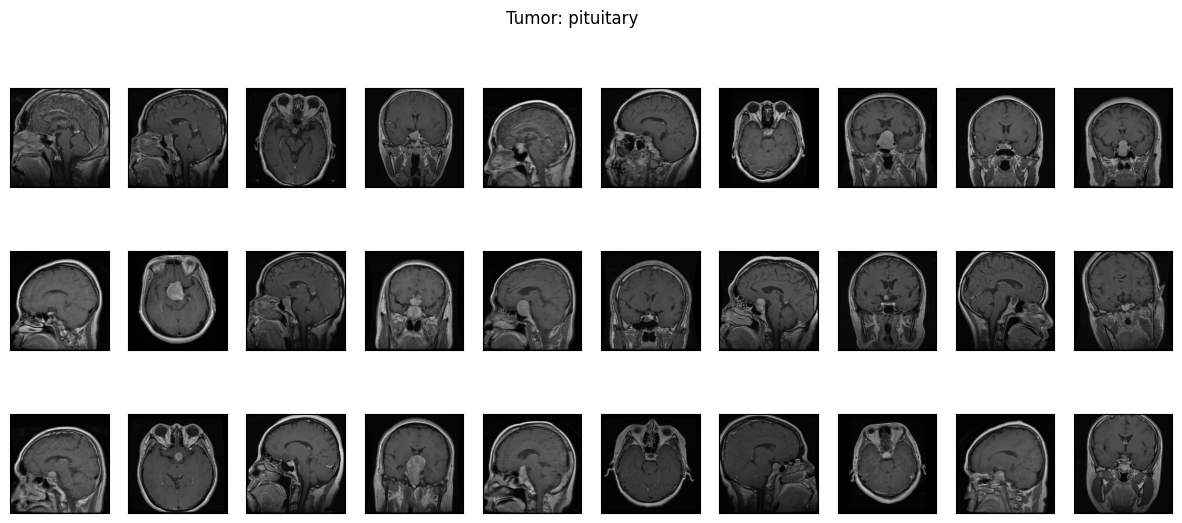

In [ ]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images </h2>

<p> The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions. </p>

<p> This cropping is done by finding contours in the images using the OpenCV Library </p>

In [ ]:
import cv2
import numpy as np
import imutils

IMG_SIZE = (224, 224)  # Example image size

def crop_imgs(set_name):
    cropped_images = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in the thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if cnts:
            c = max(cnts, key=cv2.contourArea)

            # Find the extreme points
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])

            # Crop the image
            cropped_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

            # Resize the cropped image to the desired size
            resized_cropped_img = cv2.resize(cropped_img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            cropped_images.append(resized_cropped_img)
        else:
            # If no contours are found, append the resized original image
            resized_img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            cropped_images.append(resized_img)

    return np.array(cropped_images)

# Assuming X_train, X_val, and X_test are lists or arrays of images
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

print(f"Cropped training data shape: {X_train_crop.shape}")
print(f"Cropped validation data shape: {X_val_crop.shape}")
print(f"Cropped test data shape: {X_test_crop.shape}")


Cropped training data shape: (336, 224, 224, 3)
Cropped validation data shape: (72, 224, 224, 3)
Cropped test data shape: (72, 224, 224, 3)


In [ ]:
import imutils
img = cv2.imread('/content/drive/My Drive/TRAIN/glioma/Te-gl_0021.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visualize how the cropping works </h2>

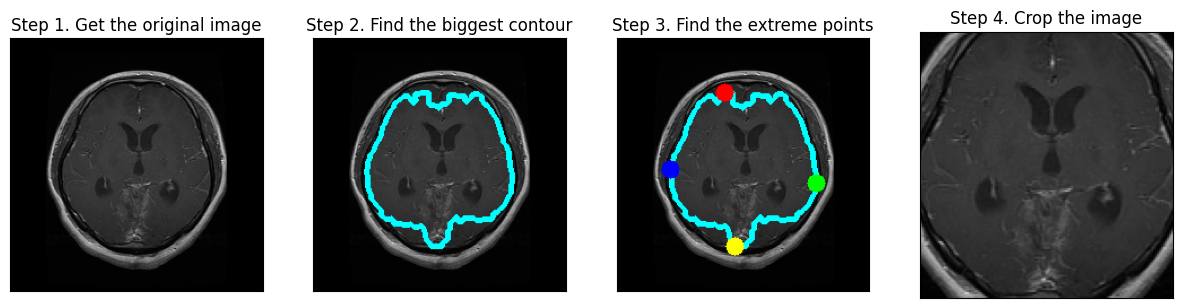

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<h2> Let's visualize the images after being cropped </h2>

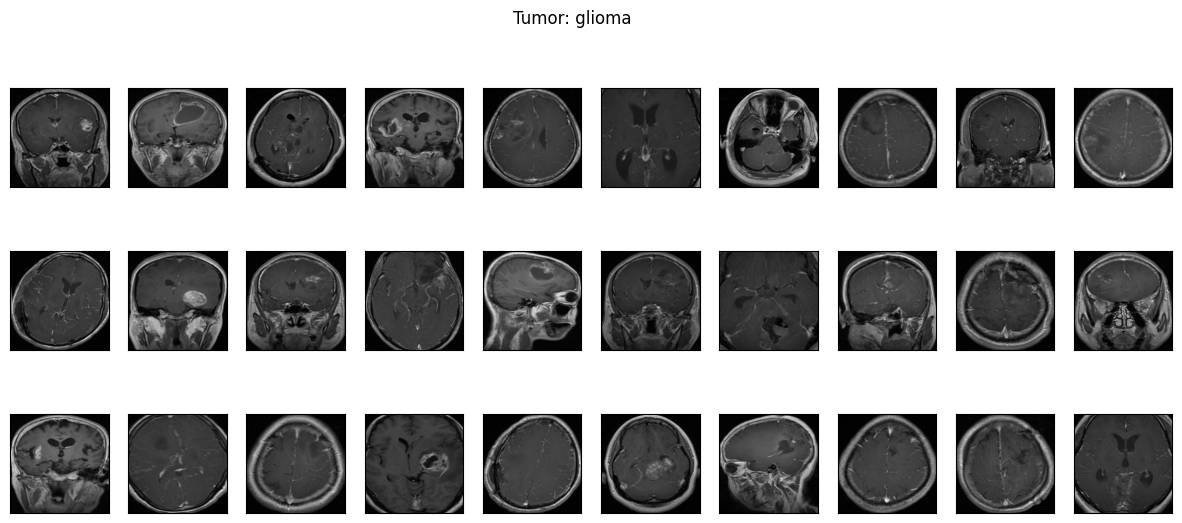

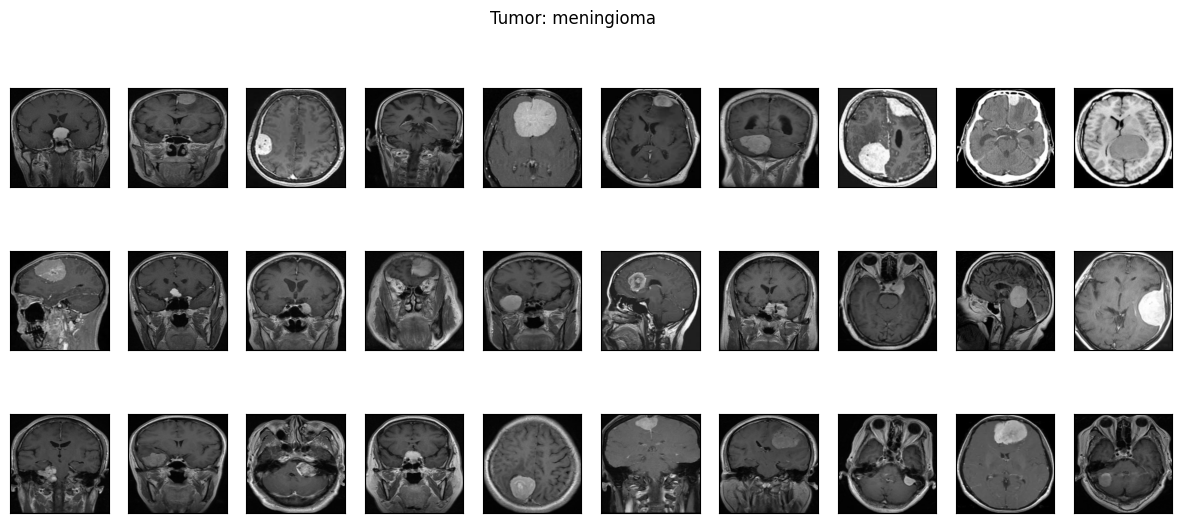

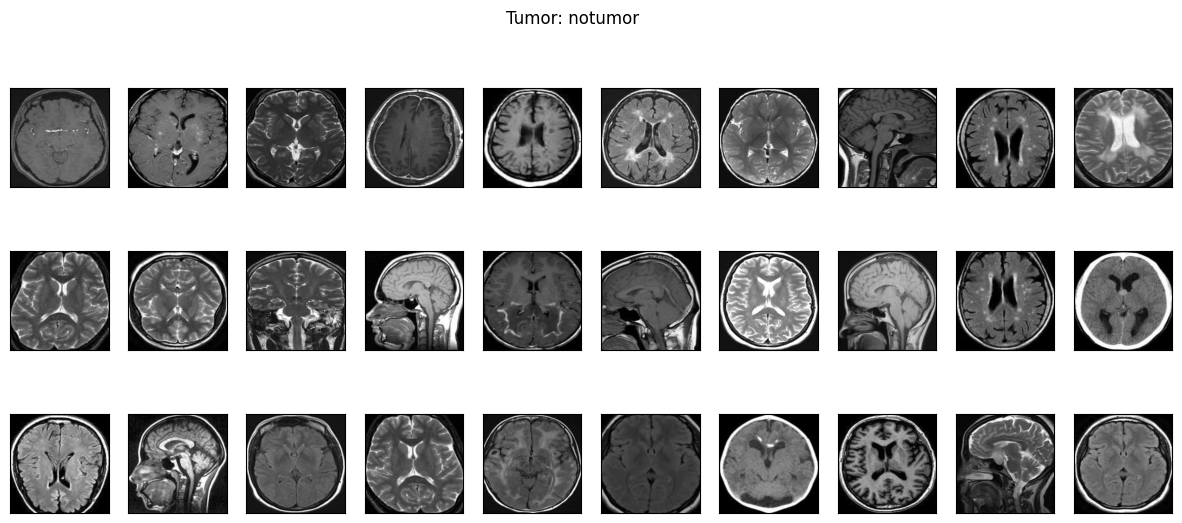

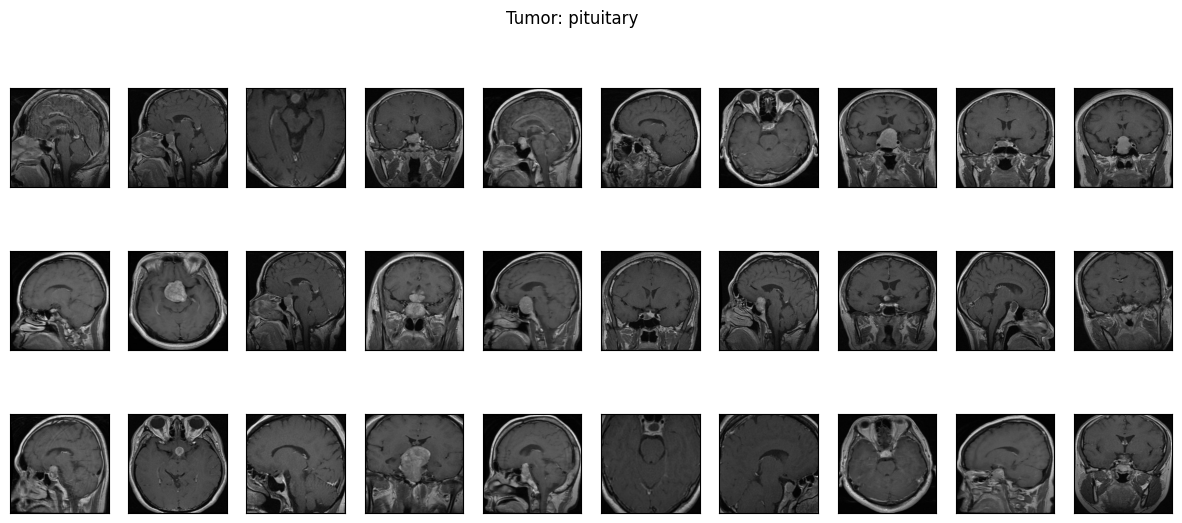

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input

# Define paths
base_dir = "/content/drive/My Drive"
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create new directories
for split in ['TRAIN_CROP', 'TEST_CROP', 'VAL_CROP']:
    for category in categories:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)
IMG_SIZE = (224, 224)  # Example image size

def load_and_preprocess_images(input_dir, img_size=IMG_SIZE):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(input_dir, category)
        class_num = categories.index(category)  # Assign a numerical label to each category
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                img = preprocess_input(img)
                images.append(img)
                labels.append(class_num)
    return np.array(images), np.array(labels)

def save_new_images(images, labels, base_output_dir):
    for img, label in zip(images, labels):
        category = categories[label]
        output_category_dir = os.path.join(base_output_dir, category)
        img_name = f"{label}_{np.random.randint(100000)}.jpg"  # Generate a unique filename
        output_path = os.path.join(output_category_dir, img_name)
        # Convert image back from float32 to uint8
        img = ((img + 1) * 127.5).astype(np.uint8)
        cv2.imwrite(output_path, img)

# Load and preprocess images
train_images, train_labels = load_and_preprocess_images(os.path.join(base_dir, 'TRAIN'), IMG_SIZE)
val_images, val_labels = load_and_preprocess_images(os.path.join(base_dir, 'VAL'), IMG_SIZE)
test_images, test_labels = load_and_preprocess_images(os.path.join(base_dir, 'TEST'), IMG_SIZE)

# Save the processed images to new directories
save_new_images(train_images, train_labels, os.path.join(base_dir, 'TRAIN_CROP'))
save_new_images(val_images, val_labels, os.path.join(base_dir, 'VAL_CROP'))
save_new_images(test_images, test_labels, os.path.join(base_dir, 'TEST_CROP'))


<h2> Resizing the images </h2>

<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts </p>

In [ ]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

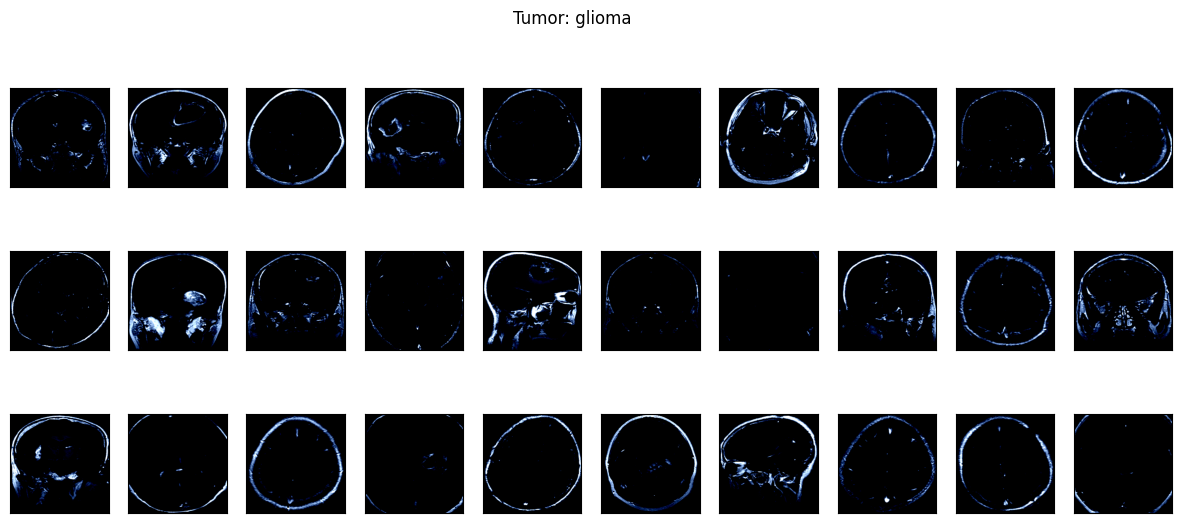

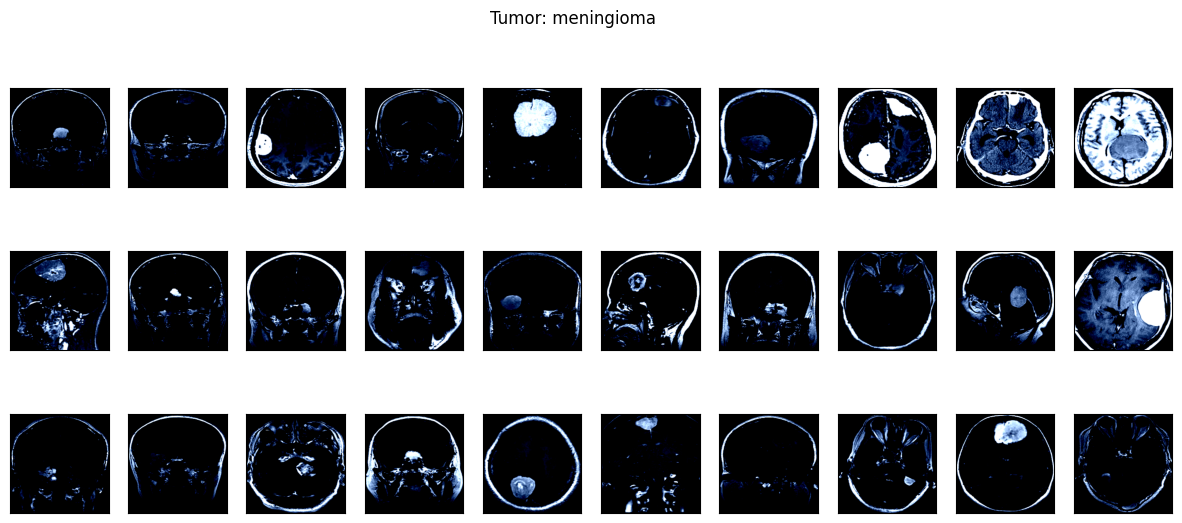

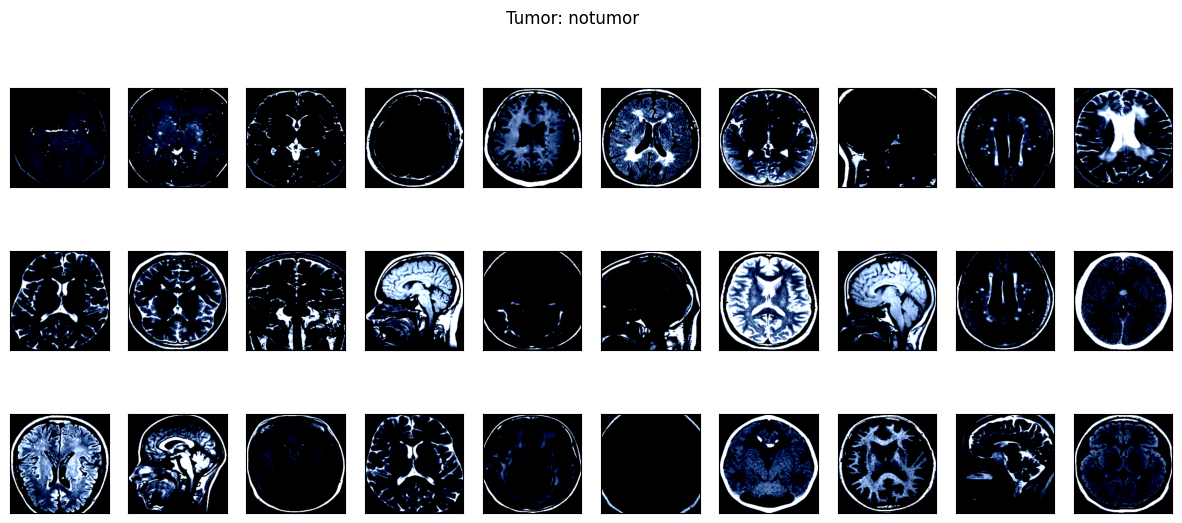

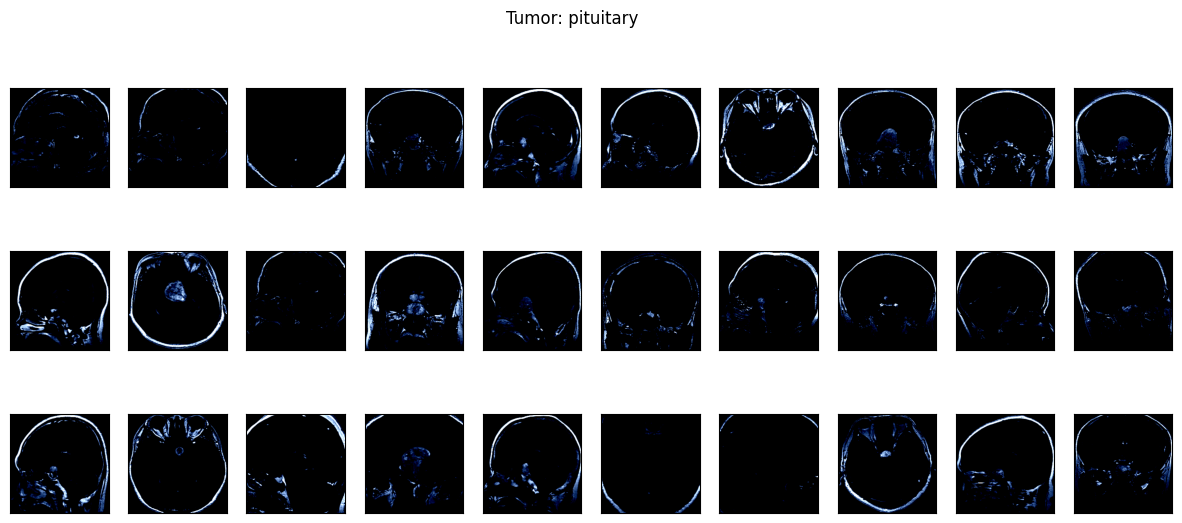

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have </p>

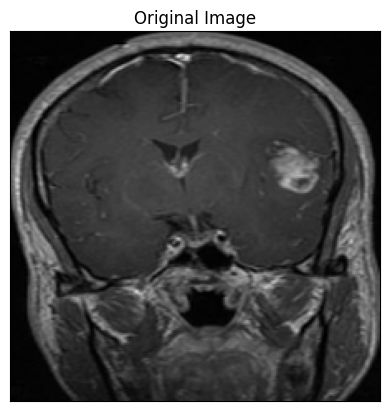

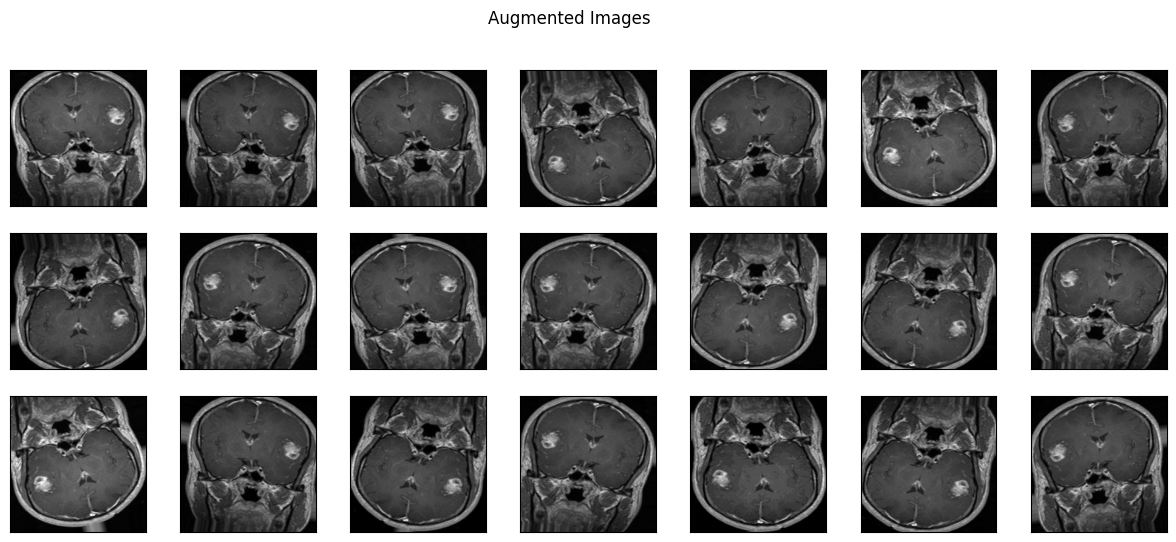

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with various augmentations
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Create a directory to save augmented images
os.makedirs('preview', exist_ok=True)

# Select the first image from the training set and reshape it
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

# Generate and save augmented images
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

# Display the original image
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Display the augmented images
plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview/'):
    img = cv2.imread(os.path.join('preview', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()


In [ ]:
!rm -rf preview/

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121

# Define paths
TRAIN_DIR = '/content/drive/My Drive/TRAIN_CROP'
VAL_DIR = '/content/drive/My Drive/VAL_CROP'
IMG_SIZE = (224, 224)
RANDOM_SEED = 42
EPOCHS = 30

# Data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',  # For multi-class classification
    seed=RANDOM_SEED
)

# Check class indices
print(train_generator.class_indices)
print(validation_generator.class_indices)


Found 1669 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


<h2> Creating the model </h2>

<p> Here we will be using a pretrained DenseNet169 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [ ]:
# Define the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 7564356 (28.86 MB)
Trainable params: 7480708 (28.54 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


> <h2> TRAINING !!! </h2>

In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[es]
)

Epoch 1/10
52/52 [==============================] - 1253s 23s/step - loss: 0.7624 - accuracy: 0.7190 - val_loss: 43.0311 - val_accuracy: 0.3324
Epoch 2/10
52/52 [==============================] - 1210s 23s/step - loss: 0.4490 - accuracy: 0.8259 - val_loss: 9.0570 - val_accuracy: 0.4006
Epoch 3/10
52/52 [==============================] - 1198s 23s/step - loss: 0.3320 - accuracy: 0.8803 - val_loss: 4.1962 - val_accuracy: 0.3523
Epoch 4/10
52/52 [==============================] - 1208s 23s/step - loss: 0.2197 - accuracy: 0.9157 - val_loss: 9.8909 - val_accuracy: 0.3920
Epoch 5/10
52/52 [==============================] - 1218s 23s/step - loss: 0.2041 - accuracy: 0.9261 - val_loss: 0.7297 - val_accuracy: 0.8295
Epoch 6/10
52/52 [==============================] - 1225s 24s/step - loss: 0.1674 - accuracy: 0.9381 - val_loss: 1.2607 - val_accuracy: 0.7585
Epoch 7/10
52/52 [==============================] - 1162s 22s/step - loss: 0.1326 - accuracy: 0.9511 - val_loss: 2.4028 - val_accuracy: 0.730

<h2>Let's have a look at the performance of our model </h2>

<h2> Let's see the other performance metrics on the test set </h2>

3/3 [==============================] - 11s 2s/step
Test Accuracy = 0.28


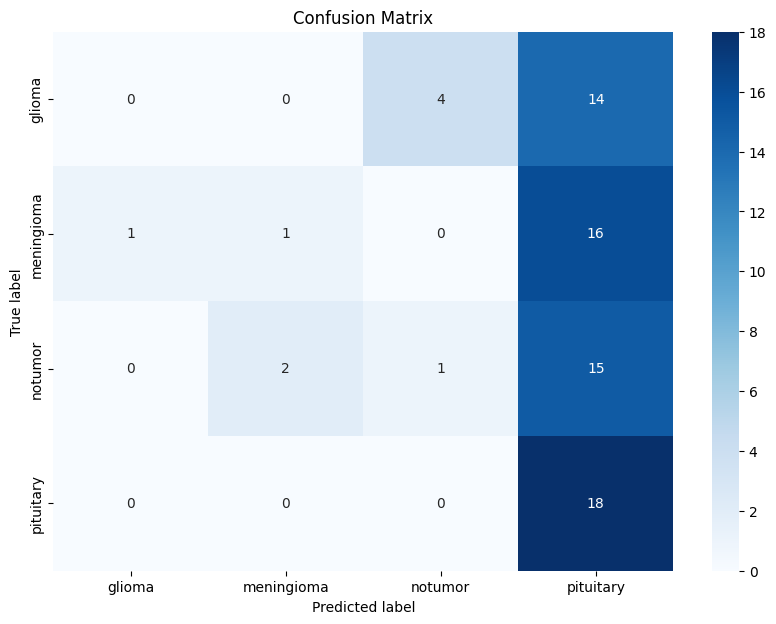

Accuracy score is : 0.2777777777777778
Precision score is : 0.20476190476190476
Recall score is : 0.2777777777777778
F1 Score is : 0.15665976535541754
ROC AUC Score is : 0.5959362139917695
Cohen Kappa Score: 0.03703703703703709
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.33      0.06      0.10        18
           2       0.20      0.06      0.09        18
           3       0.29      1.00      0.44        18

    accuracy                           0.28        72
   macro avg       0.20      0.28      0.16        72
weighted avg       0.20      0.28      0.16        72



In [ ]:
# Validate on test set
predictions = model.predict(X_test_prep)
predicted_classes = np.argmax(predictions, axis=1)
prob_pred = predictions  # Since predictions are probabilities for multi-class

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, predicted_classes)
print('Test Accuracy = %.2f' % accuracy)

# Compute confusion matrix
confusion_mtx = metrics.confusion_matrix(y_test, predicted_classes)
class_labels = list(train_generator.class_indices.keys())
plot_confusion_matrix(confusion_mtx, classes=class_labels, normalize=False, title='Confusion Matrix')

# Print various metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, predicted_classes))
print('Precision score is :', metrics.precision_score(y_test, predicted_classes, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, predicted_classes, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, predicted_classes, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, prob_pred, multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, predicted_classes))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, predicted_classes))

<h2> Conclusion </h2>
<p> A seen from the metrics, the model performs pretty well. We are able to correctly classify all the images in the test set with very few false positives and false negatives in the validation set. This performance can be firther enhanced by hyper parameter tuning. </p>

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP

1/1 [==============================] - 0s 163ms/step


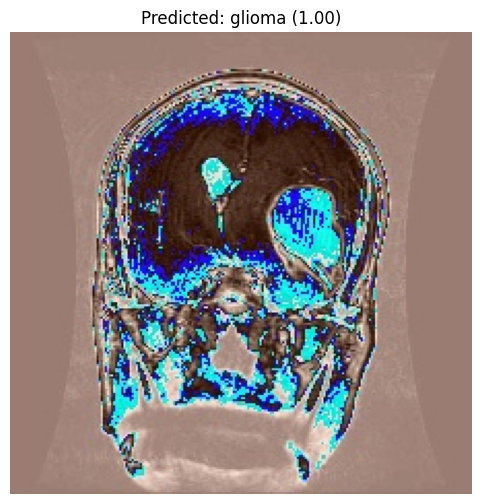

In [ ]:
# Define class labels based on the generator's class indices
class_labels = list(train_generator.class_indices.keys())

def plot_prediction(image_path, model, class_labels):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence_score = np.max(prediction)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence_score:.2f})')
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path = '/content/drive/My Drive/VAL_CROP/glioma/0_4690.jpg'
plot_prediction(test_image_path, model, class_labels)
